## Multidimensional regression with GPR and ANNs.

5.1 Create a dataset without noise as follows:

* Select 2 noiseless test functions from each of the 6 categories of the following website: https://www.sfu.ca/~ssurjano/optimization.html. Consider the domain of analysis as suggested in the website.
* Create a dataset similar to what you did in 2.1, but now considering 60 points. Use the same split strategy (in the same proportion of training/testing set).
* You don’t need to create a pandas dataframe for each dataset.
* Use both methods of Part 2 (GPR and ANN) with the same hyperparameters: GPR with RBF kernel, and ANN m

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean, stdev

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels  import RBF

from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping # a strategy for complexity control
from tensorflow import keras # fast library for ANNs
from tensorflow.keras.optimizers import Adam # import the optimizer you want to use to calculate the parameters
from keras.models import Sequential # to create a feedforward neural network
from keras.layers.core import Dense # to create a feedforward neural network with dense layers

Function that creates the dataset without noise and `N` points with set seed.
Sorts the points in ascending order and stores them in a Pandas Dataframe

In [6]:
def create_dataset(func, N=60, seed=24):
    np.random.seed(seed)
    x = np.random.uniform(func.bounds[0],func.bounds[1],(N)).reshape(-1,1) #1D
    y = func.eval(x)
    sort = np.argsort(x.ravel())
    noiseless_data = pd.DataFrame(data={'x':x[sort].ravel(), 'y':y[sort].ravel()})
    return noiseless_data

Function that splits the data into a training and testing set

In [7]:
def split(dataset, size=0.2, state=81):
    Xtrn, Xtst, ytrn, ytst = train_test_split(dataset['x'].to_numpy().reshape(-1,1),\
            dataset['y'].to_numpy(), test_size=size, random_state=state)
    train, test  = (Xtrn, ytrn), (Xtst, ytst)
    return train, test

Fits a GPR model with k-fold cross-validation. Outputs the mean and standard deviation of the $R^2$ and $\mathrm{MSE}$

In [8]:
def run_model_GPR(model, dataset):
    train, test = split(dataset)
    kf = KFold(n_splits=6)
    Xtrns, ytrns = train
    r2s, mses = [], []
    for itrn, itst in kf.split(Xtrns):
        Xtrn, ytrn = Xtrns[itrn].reshape(-1,1), ytrns[itrn]
        Xtst, ytst = Xtrns[itst].reshape(-1,1), ytrns[itst]
        model.fit(Xtrn, ytrn)
            
        ypred = model.predict(Xtst)
        r2s.append(r2_score(ytst, ypred))
        mses.append(mean_squared_error(ytst, ypred))
        
    
    return [(mean(r2s), stdev(r2s)),(mean(mses), stdev(mses))]

In [9]:
def experiment_GPR(func, kernel=RBF()):
    dataset = create_dataset(func)
    model = GPR(kernel=kernel, n_restarts_optimizer=10)
    err = run_model_GPR(model, dataset)
    #print('Function: {}'.format(func.__class__.__name__))
    #print('R2:{} / MSE:{}'.format(err[0],err[1]))
    #print('\n')
    return err

Fits a Artificial Neural network model with k-fold cross-validation. Outputs the mean and standard deviation of the $R^2$ and $\mathrm{MSE}$

In [10]:
# Function to create the ANN model
def create_ANN(input_dimensions=1,neurons1=200,neurons2=10,
               activation='relu',optimizer='adam'):
    
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    model.add(Dense(1)) # output layer with just one neuron (we only have one output)
    model.compile(loss='mse', optimizer=optimizer) # choose error metric and optimizer.
    
    return model

In [11]:
def experiment_ANN(func,neurons1=200, neurons2=10, epochs=1000,
                  optimizer=Adam(learning_rate=0.001)):
    
    dataset = create_dataset(func)
    
    train, test = split(dataset)
    kf = KFold(n_splits=6)
    Xtrns, ytrns = train
    
    batch_size = len(Xtrns) # considering the entire dataset for updating the weights and biases in each epoch
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
    
    r2s, mses = [], []
    for itrn, itst in kf.split(Xtrns):
        Xtrn, ytrn = Xtrns[itrn].reshape(-1,1), ytrns[itrn]
        Xtst, ytst = Xtrns[itst].reshape(-1,1), ytrns[itst]
        
        scaler = StandardScaler().fit(Xtrn)

        Xtrn_scaled=scaler.transform(Xtrn)
        Xtst_scaled=scaler.transform(Xtst)
        
        ANN_model = KerasRegressor(build_fn=create_ANN, neurons1=neurons1, neurons2=neurons2,
                                   batch_size=batch_size, epochs=epochs, optimizer=optimizer,
                                   validation_data=(scaler.transform(Xtst), ytst))  

        
        history = ANN_model.fit(Xtrn_scaled, ytrn, callbacks=[early_stopping], verbose=False) 


        ypred = history.model.predict(Xtst_scaled)
            
        r2s.append(r2_score(ytst, ypred))
        mses.append(mean_squared_error(ytst, ypred))
        
    print('Function: {}'.format(func.__class__.__name__))
    print('R2:{} / MSE:{}'.format((mean(r2s),stdev(r2s)),(mean(mses),stdev(mses))))
    print('\n')
    return [(mean(r2s), stdev(r2s)),(mean(mses), stdev(mses))]

## Loss functions

First we define a base class called `Function` that all the different function inheret from.
The `eval()` function reshapes the data and checks if any values are `NaN` or `Inf`

In [12]:
class Function():
    def eval(self, x, noise=False):
        x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
        if x.ndim == 1:
            x = np.reshape(x,(-1,len(x))) # reshape into 2d array
            
        return np.atleast_1d(self.f(x))

Each objectivefuntion is a class with its box-constrained boundaries listed as `self.bounds`.


In [13]:
class Levy(Function):
    def __init__(self):
        self.bounds = [-10,10]
        
    def f(self, x ):
        n_points, n_features = np.shape(x)
        y = np.empty((n_points,1))
        #
        for ii in range(n_points):
            z = 1 + (x[ii,:] - 1) / 4
            y[ii] = (np.sin( np.pi * z[0] )**2
                + sum( (z[:-1] - 1)**2 * (1 + 10 * np.sin( np.pi * z[:-1] + 1 )**2 ))
                +       (z[-1] - 1)**2 * (1 + np.sin( 2 * np.pi * z[-1] )**2 ))
        return y

    
    
class Ackley(Function):
    def __init__(self):
        self.bounds = [-32.768, 32.768]    
    
    def f(self, x, a=20, b=0.2, c=2*np.pi ):
        n_points, n_features = np.shape(x)
        y = np.empty((n_points,1))
        #
        for ii in range(n_points):
            s1 = sum( x[ii,:]**2 )
            s2 = sum( np.cos( c * x[ii,:] ))
            y[ii] = -a*np.exp( -b*np.sqrt( s1 / n_features )) - np.exp( s2 / n_features ) + a + np.exp(1)
        return y
#
class Rosenbrock(Function):  # rosen.m
    def __init__(self):
        self.bounds = [-5, 10]
        
    def f(self, x):    
        n_points, n_features = np.shape(x)
        y = np.empty((n_points,1))
        #
        for ii in range(n_points):
            x0 = x[ii,:-1]
            x1 = x[ii,1:]
            y[ii] = (sum( (1 - x0) **2 )
                + 100 * sum( (x1 - x0**2) **2 ))
        return y
#

class Griewank(Function):
    def __init__(self):
        self.bounds = [-600, 600]

    def f(self, x, fr=4000):
        n_points, n_features = np.shape(x)
        y = np.empty((n_points,1))
        #
        j = np.arange( 1., n_features+1 )
        for ii in range(n_points):
            s = sum( x[ii,:]**2 )
            p = np.prod( np.cos( x[ii,:] / np.sqrt(j) ))
            y[ii] = s/fr - p + 1
        return y
#
class Rastrigin(Function):  # rast.m
    def __init__(self):
        self.bounds = [-5.12, 5.12]
        
    def f(self, x):
        n_points, n_features = np.shape(x)
        y = np.empty((n_points,1))
        #
        for ii in range(n_points):
            y[ii] = 10*n_features + sum( x[ii,:]**2 - 10 *
                                    np.cos( 2 * np.pi * x[ii,:] ))
        return y

The `funclist` is a list of all the lossfunctions that we determined. 

In [14]:
funclist = [Levy(), Ackley(), Rosenbrock(), Griewank(), Rastrigin()]

/home/martin/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

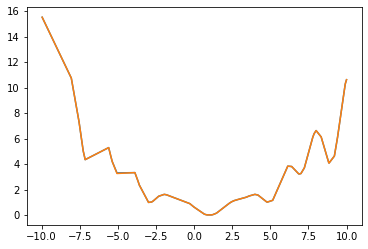

In [30]:
fig, ax = plt.figure(), plt.axes()
func = Levy()
dataset = create_dataset(func)
ax.plot(dataset['x'].values,dataset['y'].values)
model = GPR(kernel=RBF(), n_restarts_optimizer=10)
train, test = split(dataset)
X_train, y_train = train
X_test, y_test = test

X_train, y_train = X_train.reshape(-1,1), y_train
X_test, y_test = X_train.reshape(-1,1), y_train
model.fit(X_train, y_train)
            
y_pred = model.predict(X_test)

ax.plot(dataset['x'].values,model.predict(dataset['x'].values.reshape(-1,1)))

We execute the model fitting for all functions

In [12]:
results_gpr = {}
for func in funclist:
    results_gpr[func.__class__.__name__] = experiment_GPR(func)
    
results_gpr

/home/martin/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/martin/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/martin/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data 

{'Levy': [(0.6648673918010237, 0.5104202329436014),
  (5.660568156453252, 11.643194249908587)],
 'Ackley': [(-39.137231189629624, 81.40317020085628),
  (101.73178157523111, 47.75576797767409)],
 'Rosenbrock': [(1.0, 0.0), (0.0, 0.0)],
 'Griewank': [(-0.18819269588096119, 0.863241199118481),
  (789.2915389596559, 687.9881468242174)],
 'Rastrigin': [(0.5013829193771313, 0.4971806429946954),
  (33.766803765755576, 36.51462832775565)]}

In [16]:
df = pd.DataFrame(results_gpr)
df

,Levy,Ackley,Rosenbrock,Griewank,Rastrigin
0,"(0.6648673918010237, 0.5104202329436014)","(-39.137231189629624, 81.40317020085628)","(1.0, 0.0)","(-0.18819269588096119, 0.863241199118481)","(0.5013829193771313, 0.4971806429946954)"
1,"(5.660568156453252, 11.643194249908587)","(101.73178157523111, 47.75576797767409)","(0.0, 0.0)","(789.2915389596559, 687.9881468242174)","(33.766803765755576, 36.51462832775565)"


In [13]:
for func in funclist:
    experiment_ANN(func)

/tmp/ipykernel_305397/4139357511.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ANN_model = KerasRegressor(build_fn=create_ANN, neurons1=neurons1, neurons2=neurons2,
2022-03-25 15:43:16.388345: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_305397/4139357511.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ANN_model = KerasRegressor(build_fn=create_ANN, neurons1=neurons1, neurons2=neurons2,
/tmp/ipykernel_305397/4139357511.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
